In [1]:
import os
import math
import random
import copy
import queue
import time
import numpy as np
import imageio
import glob

from PIL import Image
from PIL import ImageFont
from PIL import ImageDraw 

import shutil

import matplotlib.pyplot as plt
import matplotlib
import matplotlib.cm as cm

# Introduction

Today, we are going to explore the game called "Taquin" and do a solver. The taquin is a board game of size n x n where n²-1 pieces are shuffled and we have to move them by swapping them whit the remaining position. Below we have an example of a solved one.

<img src="solved_puzzle.png" width = "200px"/>

First of all, we are going to do some stats about this puzzle and them implement few graphs search algorithms. For the rest of the Notebook we will call N the width = height of the board. The default value will be 4 which is the most common version.

# Stats

## Number of States

This is quite simple to get. For a board of size N, the 1st piece has N² position, the second one has N²-1 and so on up to 1 position. That means we have factorial(N²) arrangement of the board (20.922.789.888.000 arrangements for a 4x4 board)

In [2]:
num_arrangements = math.factorial(4*4)
num_arrangements

20922789888000

## Branching factor

Now we can have a look at the branching factor. It's the number of child a state can have. This is related to the size of the board. There is 3 cases based on the position of the free tile :

- The 4 corners have always 2 moves 
- The borders except corners have always 3 moves
- All the inner positions have 4 moves

As a result we can compute the branching factor as the number of moves possible in a grid divided by the number of cells:

\begin{align}
N_{moves} & = 4 \times 2  \\
& + 4 \times (n-2) \times 3 \\
& + (n-2)² \times 4 \\
& = 4 \times n \times (n-1)
\end{align}

\begin{align}
Branching & = \frac{4 \times n \times (n-1)}{n²}   \\
\end{align}

In theory, we can also remove the previous move and this lead to :

\begin{align}
Branching_{without\_repeat} & = \frac{4 \times n \times (n-1)}{n²} - 1   \\
\end{align}

We can plot the branching factor with the size of the board

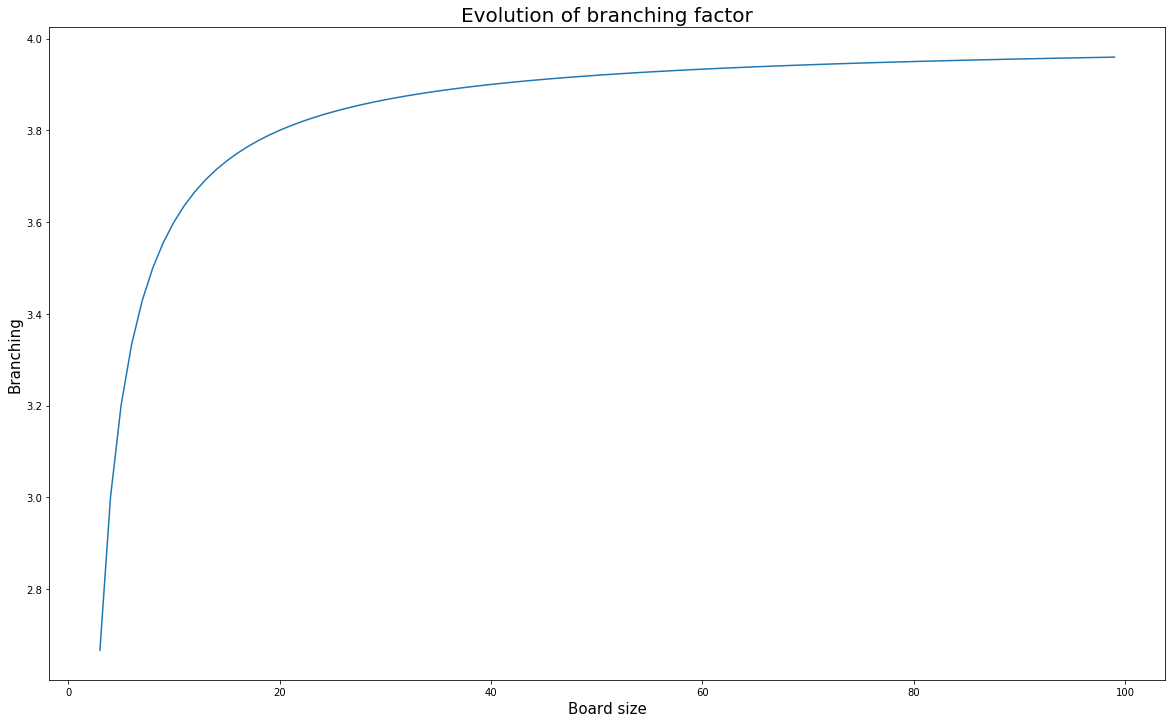

In [3]:
x = list(range(3, 100))
t = [4*i*(i-1)/(i*i) for i in x]

plt.figure(figsize=(20,12))
plt.plot(x, t)
plt.title("Evolution of branching factor", fontsize=20)
plt.xlabel("Board size", fontsize=15)
plt.ylabel("Branching", fontsize=15)
plt.show()

So the branching factor for the smallest board (3x3) is 8/3, for a 4x4 it's 3 and it rise up to 4 as for a big board, all position nearly have always 4 moves. Now with the branching factor, we can compute the number of State we can have at a specific depth (for example level 10 for a 4x4 board).

In [4]:
3 ** 10

59049

In [5]:
(3-1) **10

1024

At depth 10, if we accept to do again the previous move, we will have 59k childs. If we don't accept the previous move, we reduce it to 1024 childs. At the same way, we can calculate the number of States we will visit to visit the full graph at level 10

In [6]:
sum([ 3**n for n in range(11) ])

88573

In [7]:
sum([ 2**n for n in range(11) ])

2047

In total to visit all moves possible up to a depth of 10, we have to explore in average 88k nodes (based on the starting node, because the branching factor is an average...). If we don't accept the previous move, we reduce it to 2047.

To finish, we can check what is the depth required to have all states in our graph.

In [8]:
s = 0
n = 0
while s < num_arrangements:
    s += 3**n
    n+=1
print(n-1)

28


We can say that all 4x4 solvable taquin can be solved in 28 moves maximum.

## Solvable puzzle

All taquin cannot be solved. Only half of the possible grids may be solved so "only" 10.461.394.944.000 for a 4x4. This has been demonstrated by Sam Loyd. He proposes a method to be able to check quickly if a grid is solvable.

For each pair of number, we count the number of pairs not in the correct order. If it's even, the puzzle can be solved, else it can't be. This will be checked in the implementation just to ensure we propose to the algorithm a solvable one.

# Solver

We will try 3 algorithms:

- The first one is the BFS (Breadth First Search). It will check all States of a specific level then move to the next depth. This model is not memory efficient because we may have to store a lot of states (based on the branching) but has the benefit to find the shortest path. As a result, the storing system is a Queue.

- The second on is the DFS (Depth First Search). If we explore the grph by depth (meaning that we keep the same brach up to the end. After we move back to the previous level, explore another node and so on). This algorithm is more efficient in term of memory for low branching as we dont's have to store a complete level. The storing system is that case is the Stack

- The last one is A*. For this one will will explore the node with the best score. In our case, the heuristic chosen is sum of the manhattan distance for every tile. This is highly more efficient with a good metric as we won't explore "bad" path for nothing. In the other hand, the storing system is a bit more complex as we need a queur with priority to item with high score (low heuristic).

Due to the time required to explore the complete positions, tries will be done on a 3x3 grid

In [9]:
class Taquin():
    def __init__(self, n=4, grid=None):
        self.size = n
        self.metric = 0
        self.metric_Loyd = 0
        self.grid = grid
        self.hash = None
        if grid is None:
            self.generate(n)
        else:
            self.compute_metric_Loyd()
            if self.metric_Loyd % 2 == 1:
                print("Invalid grid, this one cannot be solved")
        self.parent = None
        self.update()
        
    def __repr__(self):
        return str(np.array(self.grid).reshape(self.size, self.size))
    
    def __lt__(self, other):
        return self.metric < other.metric
    
    def generate(self, n):
        while True:
            self.grid = list(range(1, self.size*self.size)) + ["v"]
            random.shuffle(self.grid)
            self.compute_metric_Loyd()
            if self.metric_Loyd % 2 == 0 and self.metric_Loyd > 0:
                break
    
    def compute_metric_Loyd(self):
        distance = 0
        for i in range(1, self.size*self.size):
            for j in range(i+1, self.size*self.size):
                if self.grid.index(i) > self.grid.index(j):
                    distance += 1
        self.metric_Loyd = distance
        
    def compute_metric(self):
        distance = 0
        for i in range(1, self.size*self.size):
            idx_th = ((i-1)//self.size, (i-1)%self.size)
            pos_i = self.grid.index(i)
            idx_real = (pos_i//self.size, pos_i%self.size)
            distance += abs(idx_th[0]-idx_real[0]) + abs(idx_th[1]-idx_real[1])
        self.metric = distance
    
    def compute_hash(self):
        self.hash = hash(str(self.grid))  
    
    def update(self):
        self.compute_hash()
        self.compute_metric()
    
    def swap(self, i, j):
        self.grid[i], self.grid[j] = self.grid[j], self.grid[i]
        
    def render(self):
        cmap = matplotlib.cm.get_cmap('Blues')

        temp = self.grid[:]
        temp[temp.index("v")] = 0
        
        w, h = self.size, self.size
        
        data = np.array(temp, dtype=np.float32).reshape(w, h)
        data /= data.max()
        
        img = Image.fromarray(np.uint8(cmap(data)*255))
        img = img.resize((100*w, 100*h))
        
        draw = ImageDraw.Draw(img)
        font = ImageFont.truetype("arial.ttf", 30)
        for i, txt in enumerate(temp):
            if txt != 0:
                y, x = i//self.size, i%self.size
                draw.text( 
                            ( (x+0.5)*100, (y+0.35)*100 ) , 
                            str(txt), 
                            fill=(0,0,0,255),
                            font=font
                )        
        return img

In [10]:
class Solver():
    def __init__(self, n, depth = 10, method="bfs"):
        self.method = method
        self.depth = depth
        self.record_depth = []
        self.record_metric = []
        self.visited = set()
        if self.method == "bfs":
            self.queue = queue.Queue(maxsize=0)
        elif self.method == "dfs":
            self.queue = queue.LifoQueue(maxsize=0)
        elif self.method == "a_star":
            self.queue = queue.PriorityQueue(maxsize=0)
        self.final = None
        
    def add_item(self, item, lvl = 0):
        item.update()
        if self.method == "a_star":
            self.queue.put((item.metric+lvl, lvl, item))
        else:
            self.queue.put((item.metric, lvl, item))
                
    def get_child(self, elem, lvl=0):
            index_0 = elem.grid.index("v")
            
            #check above
            if index_0 >= elem.size:
                new_elem = copy.deepcopy(elem)
                new_elem.parent = elem
                new_elem.swap(index_0, index_0 - elem.size)
                self.add_item(new_elem, lvl=lvl)

            #check below
            if index_0 <= elem.size*(elem.size-1)-1:
                new_elem = copy.deepcopy(elem)
                new_elem.parent = elem
                new_elem.swap(index_0, index_0 + elem.size)
                self.add_item(new_elem, lvl=lvl)

            #check left
            if index_0 % elem.size > 0:
                new_elem = copy.deepcopy(elem)
                new_elem.parent = elem
                new_elem.swap(index_0, index_0 - 1)
                self.add_item(new_elem, lvl=lvl)

            #check right
            if index_0 % elem.size < elem.size - 1:
                new_elem = copy.deepcopy(elem)
                new_elem.parent = elem
                new_elem.swap(index_0, index_0 + 1)
                self.add_item(new_elem, lvl=lvl)
                                
    def solve(self):
        while self.queue.qsize() > 0:
            _, depth, elem = self.queue.get()   
            if self.method == "dfs":
                self.record_depth.append(depth)
                self.record_metric.append(elem.metric)
                if elem.metric == 0:
                    return True, elem, depth
                elif depth < self.depth:
                    self.get_child(elem, lvl=depth+1)
            else:
                if elem.hash not in self.visited:
                    self.visited.add(elem.hash)
                    self.record_depth.append(depth)
                    self.record_metric.append(elem.metric)
                    if elem.metric == 0:
                        self.final = elem
                        return True, elem, depth
                    elif depth < self.depth:
                        self.get_child(elem, lvl=depth+1)
        return False, -1, self.depth
        
    def reconstruct(self):
        path = [self.final]
        temp = self.final
        while temp.parent is not None:
            path.append(temp.parent)
            temp = temp.parent
        return path[::-1]
    
    def replay(self, filename="render.gif"):
        path = self.reconstruct()
        images = []
        tempfile = "/" + str(hash(time.time())) + "/"
        os.makedirs(tempfile)
        for i, elem in enumerate(path):
            img = elem.render()
            img.save(tempfile+"{0:03d}.png".format(i))
            
        for img in glob.glob(tempfile + "*.png"):
            images.append(imageio.imread(img))
        imageio.mimsave(filename, images, duration = 0.5)
        shutil.rmtree(tempfile)

In [11]:
size = 3
depth_max = 13
# a = Taquin(size, grid = [1, 2, 3, 4, 7, 5, 6, "v", 8]) # 1 step
# a = Taquin(size, grid = ['v', 1, 3, 4, 2, 5, 7, 8, 6]) # 4 steps
a = Taquin(size, grid = [2, 3, 6, 1, 5, 4, 'v', 7, 8]) # 10 steps
# a = Taquin(size, grid = [2, 5, 8, 'v', 7, 3, 1, 4, 6]) # 15 steps
# a = Taquin(size, grid = [6, 2, 8, 5, 1, 7, 3, 'v', 4]) # 25 steps
# a = Taquin(size)
a

[['2' '3' '6']
 ['1' '5' '4']
 ['v' '7' '8']]

## BFS

In [12]:
s = Solver(n=size, depth=depth_max, method="bfs")
s.add_item(a)
start = time.time()
done, elem, steps = s.solve()
stop = time.time()
if done:
    print("Solvable in {} steps".format(steps))
else:
    print("Solution not found")
print("Computation time {:.3f}s".format(stop-start))

Solvable in 10 steps
Computation time 0.289s


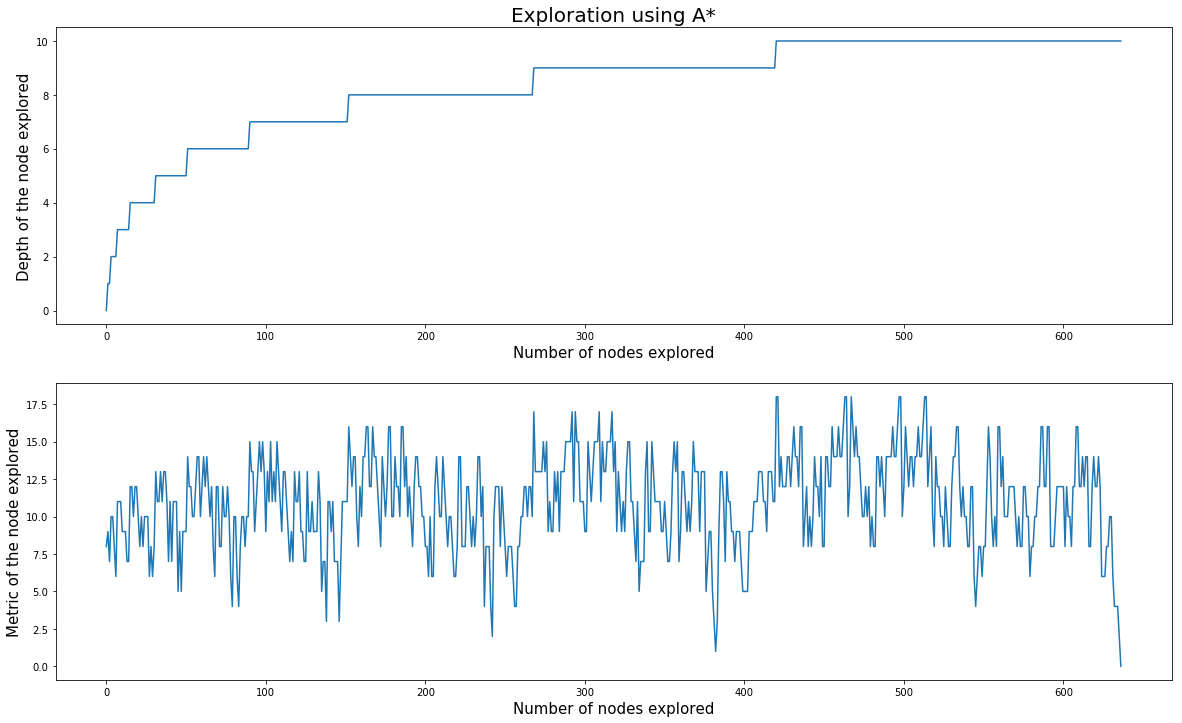

In [13]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20,12))
ax1.plot(s.record_depth)
ax2.plot(s.record_metric)
ax1.set_ylabel("Depth of the node explored", fontsize=15)
ax2.set_ylabel("Metric of the node explored", fontsize=15)
ax1.set_xlabel("Number of nodes explored", fontsize=15)
ax2.set_xlabel("Number of nodes explored", fontsize=15)
ax1.set_title("Exploration using A*", fontsize=20)
plt.show()

We can see that the depth increase by step. As soon as the algorithm find a solution, we are 100 sure that this is the shortest one (it may exist few other paths but they are at least as long as the one found). The drawback is for a deeper game (for example 40 moves) we may reach such a big number that a computer cannot compute them all in term of time but also to store the current level in memory (3^50 = 7*10e23 states to store)

## DFS

In [14]:
s = Solver(n=size, depth=depth_max, method="dfs")
s.add_item(a)
start = time.time()
done, elem, steps = s.solve()
stop = time.time()
if done:
    print("Solvable in {} steps".format(steps))
else:
    print("Solution not found")
print("Computation time {:.3f}s".format(stop-start))

Solvable in 12 steps
Computation time 6.691s


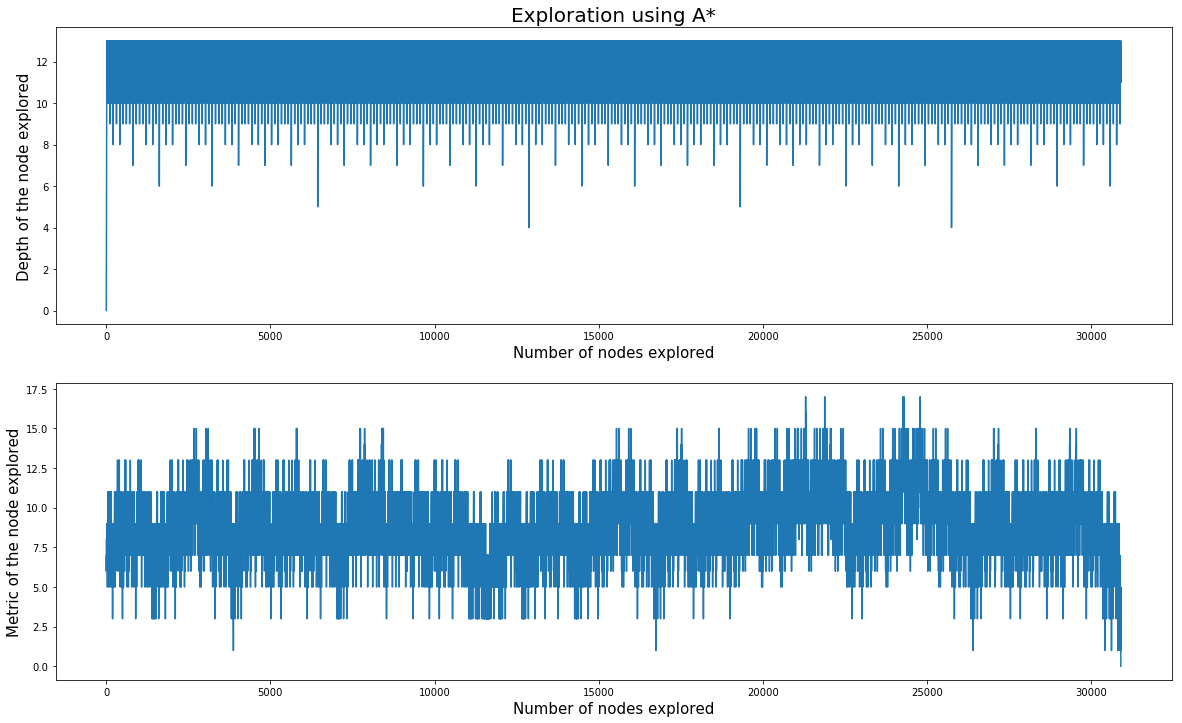

In [15]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20,12))
ax1.plot(s.record_depth)
ax2.plot(s.record_metric)
ax1.set_ylabel("Depth of the node explored", fontsize=15)
ax2.set_ylabel("Metric of the node explored", fontsize=15)
ax1.set_xlabel("Number of nodes explored", fontsize=15)
ax2.set_xlabel("Number of nodes explored", fontsize=15)
ax1.set_title("Exploration using A*", fontsize=20)
plt.show()

This algorithm is not suitable for this puzzle. The problem is taht we don't know the depth of the solution. As a result, we should estimate a value for sure above but not too much to avoid to look at too many combinations. In addition, even if we let the algorithm run. It can find fast a solution, but we cannot say that this solution is the shortest one. It's one of the solution but without exploring all the nodes of the complete graph, we cannot be sure that there is no shorter one.

## A*

In [16]:
s = Solver(n=size, depth=depth_max, method="a_star")
s.add_item(a)
start = time.time()
done, elem, steps = s.solve()
stop = time.time()
if done:
    print("Solvable in {} steps".format(steps))
else:
    print("Solution not found")
print("Computation time {:.3f}s".format(stop-start))

Solvable in 10 steps
Computation time 0.006s


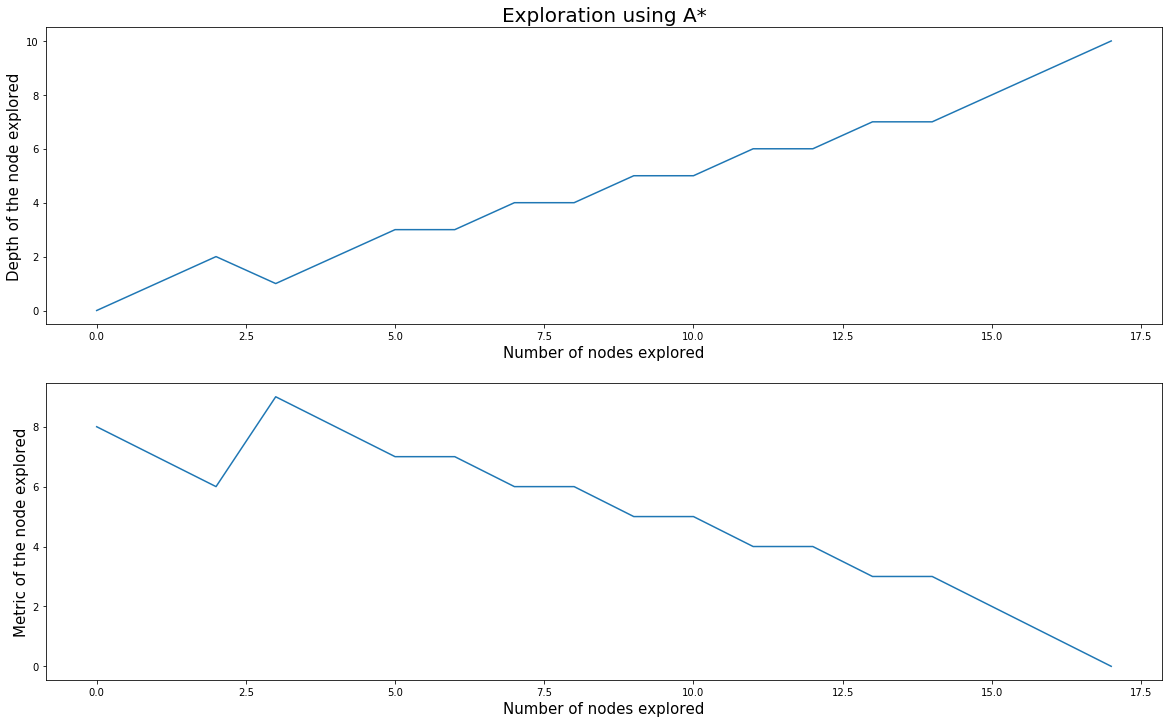

In [17]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20,12))
ax1.plot(s.record_depth)
ax2.plot(s.record_metric)
ax1.set_ylabel("Depth of the node explored", fontsize=15)
ax2.set_ylabel("Metric of the node explored", fontsize=15)
ax1.set_xlabel("Number of nodes explored", fontsize=15)
ax2.set_xlabel("Number of nodes explored", fontsize=15)
ax1.set_title("Exploration using A*", fontsize=20)
plt.show()

This one is highly more effective. As we explore only the node with the lowest metric, we are reducing the number of path to explore by a lot. In addition, if we want to go deeper, we can reduce required memory by dumping states with too high metric. This one is the most suitable. Now what we can do is try it on random grids.

# More complexe example

In [18]:
size = 3
# a = Taquin(size)
a = Taquin(size, grid = [6, 2, 8, 5, 1, 7, 3, 'v', 4]) # 25 steps
depth_max = 50

s = Solver(n=size, depth=depth_max, method="a_star")
s.add_item(a)
start = time.time()
done, elem, steps = s.solve()
stop = time.time()
if done:
    print("Solvable in {} steps".format(steps))
    s.replay()
else:
    print("Solution not found")
print("Computation time {:.3f}s".format(stop-start))
print(len(s.record_metric), "nodes explored")

Solvable in 23 steps
Computation time 0.178s
347 nodes explored


<img src="render.gif"/>

### Unfortunately, it seems that this algorithm is still not powerfull enought to solve a 4x4 boards. The time taken increase a lot due to the depth required and the width of the exploration tree

# Conclusion

We saw some algorithm to solve a "simple" puzzle. Nevertheless, we quicly realize that this simple puzzle is not as easy as expected. The complexity growth quiclky and having a solution fast for bigger grid is not doable with a simple A* algoritm. Maybe there is some pieces of code which can be improved to make the code faster (deque instale of PriorityQueue, calculation of the metric, storing of objects, removing some links in the graph like previous moves).

In a future notebook, I'll try to implement faster methods to solve at least the standard 4x4 grid in a relative low time. This will probably reauired some other solution like Alpha-beta prunning... but this is for a bit later :)